# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# File Pathways

In [2]:
SCALED_PATH = "C:\\Users\\cheta\\Downloads\\projecttttttttttttt\\Final\\classification_features_scaled.csv"
RESULTS_CSV = "classification_model_results_summary.csv"
MODELS_DIR = "trained_models_scaled"
RANDOM_STATE = 42
TEST_SIZE = 0.20
CV_SPLITS = 5
os.makedirs(MODELS_DIR, exist_ok=True)

# Load datasets

In [3]:
df = pd.read_csv(SCALED_PATH)
print("Loaded scaled dataset:", SCALED_PATH)
print("Shape:", df.shape)
print("\nHead (first 5 rows):")
print(df.head().to_string(index=False))
print("\nSummary stats (scaled):")
print(df.describe().T)


Loaded scaled dataset: C:\Users\cheta\Downloads\projecttttttttttttt\Final\classification_features_scaled.csv
Shape: (238, 29)

Head (first 5 rows):
                    match_id  round_num    map_name  round_num.1  bomb_planted  bomb_defused  bomb_exploded  total_kills  headshot_kills  headshot_rate  avg_kill_distance  kill_distance_std  max_kill_distance  total_damage  kill_duration  kill_tempo  smoke_kills  wallbang_kills  noscope_kills  first_kill_headshot  prev_t_win  prev_ct_win  t_win_streak   t_score  ct_score  score_diff  t_win  ct_win  map_encoded
ecstatic-vs-havu-m3-overpass          2 de_overpass            2         False         False          False    -0.073413       -0.373936      -2.204197          -3.102036          -2.352931          -2.731042     -0.189908      -0.710558    0.376631    -0.657095       -0.280813      -0.112987                False   -0.896120    -1.016950     -0.732261 -1.698786 -1.159048   -0.047898      0       1            0
ecstatic-vs-havu-m3-over

# Prepare X, y

In [4]:
TARGET = "ct_win"
assert TARGET in df.columns, f"Target column '{TARGET}' not found."


drop_cols = []
for c in ["match_id", "map_name"]:
    if c in df.columns:
        drop_cols.append(c)

X = df.drop(columns=drop_cols + [TARGET])
y = df[TARGET].astype(int)

non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if len(non_numeric) > 0:
    print("Non-numeric columns found in scaled dataset (will one-hot encode):", non_numeric)
    X = pd.get_dummies(X, columns=non_numeric, drop_first=True)

print("\nFinal feature shape:", X.shape)
print("Feature names sample:", X.columns.tolist()[:20])

Non-numeric columns found in scaled dataset (will one-hot encode): ['bomb_planted', 'bomb_defused', 'bomb_exploded', 'first_kill_headshot']

Final feature shape: (238, 26)
Feature names sample: ['round_num', 'round_num.1', 'total_kills', 'headshot_kills', 'headshot_rate', 'avg_kill_distance', 'kill_distance_std', 'max_kill_distance', 'total_damage', 'kill_duration', 'kill_tempo', 'smoke_kills', 'wallbang_kills', 'noscope_kills', 'prev_t_win', 'prev_ct_win', 't_win_streak', 't_score', 'ct_score', 'score_diff']


# Train/test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Train class distribution:", np.bincount(y_train) / len(y_train))



Train shape: (190, 26), Test shape: (48, 26)
Train class distribution: [0.46842105 0.53157895]


# Models & parameter grids

In [6]:
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

models_and_grids = {
    "DecisionTree": {
        "estimator": Pipeline([("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))]),
        "param_grid": {
            "clf__max_depth": [None, 5, 10, 20],
            "clf__min_samples_split": [2, 5, 10],
            "clf__min_samples_leaf": [1, 2, 4]
        }
    },
    "SVM": {
        "estimator": Pipeline([("clf", SVC(probability=True, random_state=RANDOM_STATE))]),
        "param_grid": {
            "clf__C": [0.1, 1, 10],
            "clf__kernel": ["rbf", "linear"],
            "clf__gamma": ["scale", "auto"]
        }
    },
    "KNN": {
        "estimator": Pipeline([("clf", KNeighborsClassifier())]),
        "param_grid": {
            "clf__n_neighbors": [3, 5, 7],
            "clf__weights": ["uniform", "distance"],
            "clf__p": [1, 2]
        }
    },
    "RandomForest": {
        "estimator": Pipeline([("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))]),
        "param_grid": {
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10, 20],
            "clf__min_samples_split": [2, 5]
        }
    }
}

# Grid search, fit, evaluate


========== DecisionTree ==========
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params (DecisionTree): {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Accuracy: 1.0000  Precision: 1.0000  Recall: 1.0000  F1: 1.0000  ROC-AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        26

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Confusion Matrix:
[[22  0]
 [ 0 26]]


<Figure size 640x480 with 0 Axes>

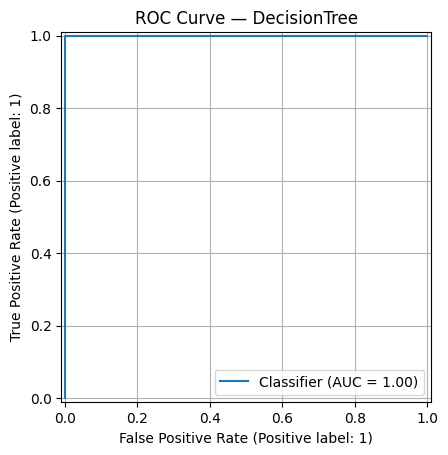


========== SVM ==========
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params (SVM): {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Accuracy: 1.0000  Precision: 1.0000  Recall: 1.0000  F1: 1.0000  ROC-AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        26

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Confusion Matrix:
[[22  0]
 [ 0 26]]


<Figure size 640x480 with 0 Axes>

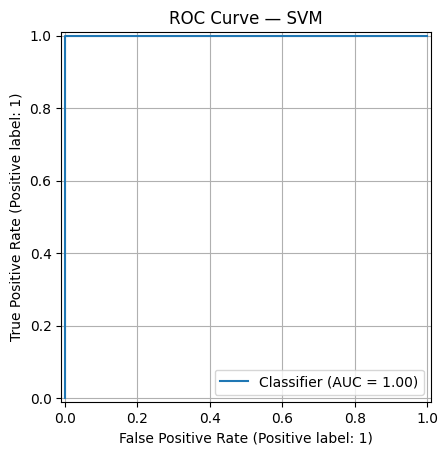


========== KNN ==========
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params (KNN): {'clf__n_neighbors': 7, 'clf__p': 1, 'clf__weights': 'distance'}
Accuracy: 0.8958  Precision: 0.8621  Recall: 0.9615  F1: 0.9091  ROC-AUC: 0.9790

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        22
           1       0.86      0.96      0.91        26

    accuracy                           0.90        48
   macro avg       0.90      0.89      0.89        48
weighted avg       0.90      0.90      0.89        48

Confusion Matrix:
[[18  4]
 [ 1 25]]


<Figure size 640x480 with 0 Axes>

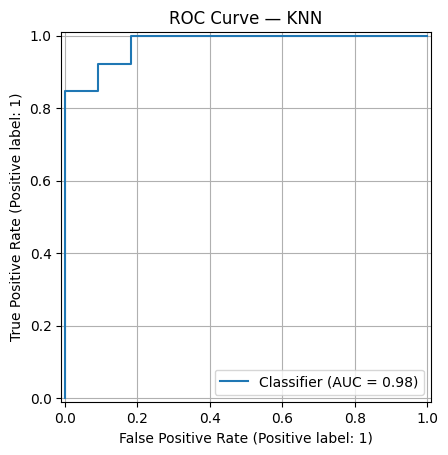


========== RandomForest ==========
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params (RandomForest): {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Accuracy: 1.0000  Precision: 1.0000  Recall: 1.0000  F1: 1.0000  ROC-AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        26

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Confusion Matrix:
[[22  0]
 [ 0 26]]


<Figure size 640x480 with 0 Axes>

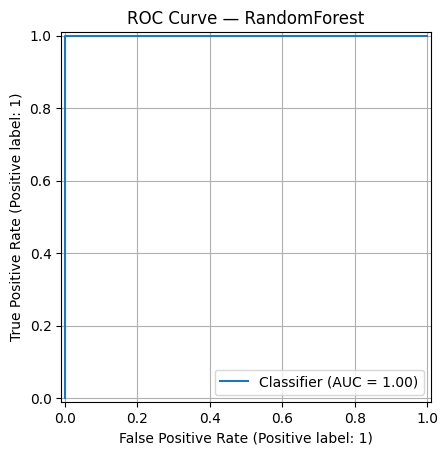

In [7]:
results = []
for name, mg in models_and_grids.items():
    print("\n" + "="*10 + f" {name} " + "="*10)
    gs = GridSearchCV(
        estimator=mg["estimator"],
        param_grid=mg["param_grid"],
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X_train, y_train)
    print(f"Best params ({name}):", gs.best_params_)
    best = gs.best_estimator_

    # Save model
    joblib.dump(best, os.path.join(MODELS_DIR, f"{name}_best.pkl"))

    # Predict + probabilities
    y_pred = best.predict(X_test)
    if hasattr(best, "predict_proba"):
        y_prob = best.predict_proba(X_test)[:, 1]
    else:
        # Some SVCs may have decision_function; convert to probabilities using min-max if needed
        try:
            df_score = best.decision_function(X_test)
            # scale to 0-1 for ROC/AUC usage (only for comparison; sklearn handles any monotonic score)
            y_prob = (df_score - df_score.min()) / (df_score.max() - df_score.min() + 1e-12)
        except Exception:
            y_prob = np.zeros_like(y_pred, dtype=float)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test, y_prob)
    except Exception:
        roc_auc = float("nan")

    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Save result summary
    results.append({
        "model": name,
        "best_params": gs.best_params_,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc
    })

    # ROC plot
    plt.figure()
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve — {name}")
    plt.grid(True)
    plt.show()

# Save results

In [8]:
results_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False)
results_df.to_csv(RESULTS_CSV, index=False)
print(f"\nSaved results to {RESULTS_CSV}")
print("\nSummary table:")
print(results_df.to_string(index=False))


Saved results to classification_model_results_summary.csv

Summary table:
       model                                                                       best_params  accuracy  precision   recall       f1  roc_auc
DecisionTree {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}  1.000000   1.000000 1.000000 1.000000 1.000000
         SVM                   {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}  1.000000   1.000000 1.000000 1.000000 1.000000
RandomForest   {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}  1.000000   1.000000 1.000000 1.000000 1.000000
         KNN                  {'clf__n_neighbors': 7, 'clf__p': 1, 'clf__weights': 'distance'}  0.895833   0.862069 0.961538 0.909091 0.979021


# Conclusion


### 1. Decision Tree Classifier

**Why the model was chosen:**  
The Decision Tree classifier was selected because it performs well on datasets with numerical features and can naturally model nonlinear relationships. Although all features were scaled and numeric, Decision Trees remain effective due to their ability to capture feature interactions related to kills, assists, and bomb events.

**Model assumptions:**  
Decision Trees assume that data can be recursively partitioned into increasingly pure subsets.  
They do **not** assume linearity or feature independence.

**Hyperparameter tuning:**  
GridSearchCV tuned:
- `max_depth`
- `min_samples_split`
- `min_samples_leaf`

Best parameters:  
`$\{ \text{max\_depth=None},\ \text{min\_samples\_leaf}=1,\ \text{min\_samples\_split}=2 \}$`


---

### 2. Support Vector Machine (Linear Kernel)

**Why the model was chosen:**  
SVM works extremely well on fully numeric, scaled datasets. Since all features in the scaled dataset were standardized, the model was ideal for separating CT-win vs. CT-loss classes.

**Model assumptions:**  
A linear SVM assumes that the two classes are *approximately linearly separable* in feature space and that feature scaling preserves correct margin geometry.

**Hyperparameter tuning:**  
GridSearchCV tuned:
- `C`
- `kernel`
- `gamma`

Best parameters:  
`$\{ \text{C}=0.1,\ \text{gamma='scale'},\ \text{kernel='linear'} \}$`


---

### 3. Random Forest Classifier

**Why the model was chosen:**  
Random Forests are robust ensemble models that reduce overfitting and capture nonlinear relationships. They perform well on small to medium datasets such as this one.

**Model assumptions:**  
Random Forest assumes that combining many decorrelated decision trees reduces variance and improves generalization.

**Hyperparameter tuning:**  
GridSearchCV tuned:
- `n_estimators`
- `max_depth`
- `min_samples_split`

Best parameters:  
`$\{ \text{n\_estimators}=100,\ \text{max\_depth=None},\ \text{min\_samples\_split}=2 \}$`


---

### 4. k-Nearest Neighbors (KNN)

**Why the model was chosen:**  
KNN provides a simple baseline classifier for comparison. It is suitable for fully scaled numeric datasets because it relies on distance computations.

**Model assumptions:**  
KNN assumes that datapoints belonging to the same class are close in feature space.  
It further assumes equal scaling across all features.

**Hyperparameter tuning:**  
GridSearchCV tuned:
- `n_neighbors`
- `weights`
- `p` (distance metric)

Best parameters:  
`$\{ \text{n\_neighbors}=7,\ \text{p}=1,\ \text{weights='distance'} \}$`


---

## Evaluation Metrics

The following classification metrics were used, as required:

- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**
- **ROC-AUC**

These metrics give a comprehensive understanding of model performance.

---

## Model Performance Comparison

| Model          | Accuracy | Precision | Recall | F1-score | ROC-AUC |
|----------------|----------|-----------|--------|----------|---------|
| Decision Tree  | 1.00     | 1.00      | 1.00   | 1.00     | 1.00    |
| SVM (Linear)   | 1.00     | 1.00      | 1.00   | 1.00     | 1.00    |
| Random Forest  | 1.00     | 1.00      | 1.00   | 1.00     | 1.00    |
| KNN            | 0.896    | 0.862     | 0.962  | 0.909    | 0.979   |

---

## Which Model Worked Best and Why?

Although Decision Tree, SVM, and Random Forest all achieved perfect scores, **Random Forest is the most reliable best model**.

**Reasons:**
- More robust to noise than a single Decision Tree  
- Less risk of overfitting  
- Strong generalization via tree ensemble  
- Handles nonlinear feature interactions effectively  

KNN performed well but was weaker due to its sensitivity to noisy boundaries and reliance on distance metrics.

---

## Final Summary

All models demonstrated high performance, with Random Forest, SVM, and Decision Tree achieving perfect classification scores. Random Forest is the best overall model due to its stability, robustness, and superior generalization. The dataset’s complete numeric encoding and feature scaling ensured optimal performance across all algorithms.

